In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

In [4]:
seed = 543
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [5]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed)

In [7]:
print(env.observation_space)
print(env.action_space)
initial_state = env.reset()
print(initial_state)

Box(-inf, inf, (8,), float32)
Discrete(4)
[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


In [8]:
random_action = env.action_space.sample()
print(random_action)

0


In [9]:
observation, reward, done, info = env.step(random_action)
print(done)

False


In [10]:
print(reward)

-0.8588900517154912


In [21]:
# 使用Actor Critic
from torch.optim.lr_scheduler import StepLR
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(8, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh()
        )
        
        self.actor = nn.Linear(16, 4)
        self.critic = nn.Linear(16, 1)
        
        self.values = []
        self.optimizer = optim.Adam(self.parameters(), lr=0.002)
        
    def forward(self, state):
        hid = self.fc(state)
        self.values.append(self.critic(hid).squeeze(-1))
        return F.softmax(self.actor(hid), dim=-1)

    def learn(self, log_probs, rewards):
        values = torch.stack(self.values)
        loss = (-log_probs * (rewards - values.detach())).sum() + F.smooth_l1_loss(values, rewards)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.values = []
    
    def sample(self, state):
        action_prob = self(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

In [22]:
agent = ActorCritic()
agent.train()
episodes = 5
epochs = 500
rate = 0.99

avg_total_rewards, avg_final_rewards = [], []

bar = tqdm(range(epochs))
for epoch in bar:
    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:
            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)
            seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                for i in range(2, len(seq_rewards)+1):
                    seq_rewards[-i] += rate * (seq_rewards[-i+1])
                rewards += seq_rewards
                break
                    
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9) 
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print(f"Epoch: {epoch}, total rewards:{avg_total_reward: 4.1f}, final rewards: {avg_final_reward: 4.1f} ")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0, total rewards:-239.6, final rewards: -100.0 
Epoch: 1, total rewards:-365.2, final rewards: -100.0 
Epoch: 2, total rewards:-224.0, final rewards: -100.0 
Epoch: 3, total rewards:-191.7, final rewards: -100.0 
Epoch: 4, total rewards:-129.5, final rewards: -100.0 
Epoch: 5, total rewards:-213.5, final rewards: -100.0 
Epoch: 6, total rewards:-209.3, final rewards: -100.0 
Epoch: 7, total rewards:-228.6, final rewards: -100.0 
Epoch: 8, total rewards:-113.4, final rewards: -100.0 
Epoch: 9, total rewards:-248.4, final rewards: -100.0 
Epoch: 10, total rewards:-154.9, final rewards: -100.0 
Epoch: 11, total rewards:-153.0, final rewards: -100.0 
Epoch: 12, total rewards:-150.4, final rewards: -100.0 
Epoch: 13, total rewards:-128.2, final rewards: -100.0 
Epoch: 14, total rewards:-162.8, final rewards: -100.0 
Epoch: 15, total rewards:-113.3, final rewards: -100.0 
Epoch: 16, total rewards:-165.7, final rewards: -100.0 
Epoch: 17, total rewards:-129.8, final rewards: -100.0 
Ep

Epoch: 146, total rewards:-95.7, final rewards: -100.0 
Epoch: 147, total rewards:-67.5, final rewards: -100.0 
Epoch: 148, total rewards:-122.1, final rewards: -100.0 
Epoch: 149, total rewards:-119.9, final rewards: -100.0 
Epoch: 150, total rewards:-91.6, final rewards: -100.0 
Epoch: 151, total rewards:-100.6, final rewards: -100.0 
Epoch: 152, total rewards:-71.0, final rewards: -100.0 
Epoch: 153, total rewards:-115.8, final rewards: -100.0 
Epoch: 154, total rewards:-116.7, final rewards: -100.0 
Epoch: 155, total rewards:-117.3, final rewards: -100.0 
Epoch: 156, total rewards:-71.9, final rewards: -100.0 
Epoch: 157, total rewards:-86.5, final rewards: -100.0 
Epoch: 158, total rewards:-112.6, final rewards: -100.0 
Epoch: 159, total rewards:-108.2, final rewards: -100.0 
Epoch: 160, total rewards:-81.4, final rewards: -100.0 
Epoch: 161, total rewards:-73.7, final rewards: -100.0 
Epoch: 162, total rewards:-75.3, final rewards: -100.0 
Epoch: 163, total rewards:-71.4, final r

Epoch: 294, total rewards: 59.4, final rewards: -39.6 
Epoch: 295, total rewards: 46.6, final rewards: -39.9 
Epoch: 296, total rewards: 48.7, final rewards: -60.1 
Epoch: 297, total rewards: 82.1, final rewards: -20.0 
Epoch: 298, total rewards: 62.7, final rewards: -59.9 
Epoch: 299, total rewards: 61.6, final rewards: -19.6 
Epoch: 300, total rewards: 82.8, final rewards: -40.1 
Epoch: 301, total rewards: 47.8, final rewards: -60.0 
Epoch: 302, total rewards: 88.8, final rewards: -39.7 
Epoch: 303, total rewards: 91.6, final rewards: -20.4 
Epoch: 304, total rewards: 50.2, final rewards: -40.6 
Epoch: 305, total rewards: 103.7, final rewards: -20.0 
Epoch: 306, total rewards: 50.9, final rewards: -60.2 
Epoch: 307, total rewards: 101.6, final rewards: -20.1 
Epoch: 308, total rewards:-6.2, final rewards: -80.0 
Epoch: 309, total rewards: 19.8, final rewards: -79.9 
Epoch: 310, total rewards: 46.0, final rewards: -39.9 
Epoch: 311, total rewards: 72.3, final rewards: -40.0 
Epoch: 31

Epoch: 443, total rewards: 147.2, final rewards: -0.2 
Epoch: 444, total rewards: 139.5, final rewards: -19.9 
Epoch: 445, total rewards: 85.8, final rewards: -39.8 
Epoch: 446, total rewards: 103.0, final rewards: -40.0 
Epoch: 447, total rewards: 128.7, final rewards: -20.0 
Epoch: 448, total rewards: 119.8, final rewards: -0.0 
Epoch: 449, total rewards: 117.4, final rewards: -20.1 
Epoch: 450, total rewards: 133.6, final rewards: -20.1 
Epoch: 451, total rewards: 115.3, final rewards: -40.1 
Epoch: 452, total rewards: 127.7, final rewards: -20.2 
Epoch: 453, total rewards: 97.9, final rewards: -40.0 
Epoch: 454, total rewards: 62.4, final rewards: -60.1 
Epoch: 455, total rewards: 111.4, final rewards: -20.0 
Epoch: 456, total rewards: 120.0, final rewards: -20.1 
Epoch: 457, total rewards: 94.9, final rewards: -39.8 
Epoch: 458, total rewards: 82.2, final rewards: -40.2 
Epoch: 459, total rewards: 85.4, final rewards: -60.3 
Epoch: 460, total rewards: 101.6, final rewards: -40.2 


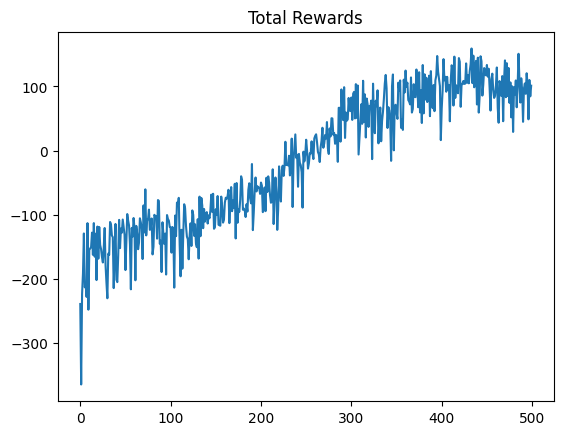

In [23]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

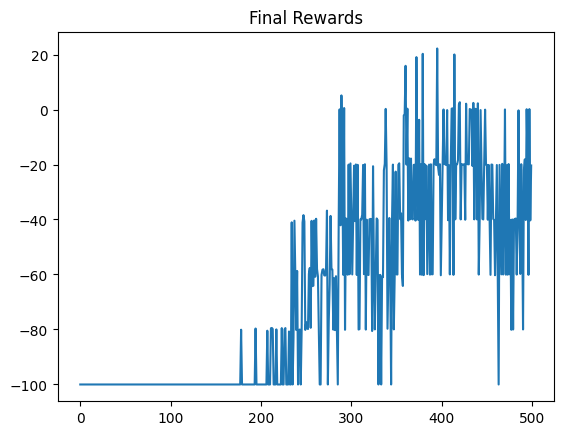

In [24]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

In [33]:
fix(env, seed)
agent.eval()  
NUM_OF_TEST = 5 
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
    actions = []
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action,_ = agent.sample(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)
        total_reward += reward
    
    print(total_reward)
    test_total_reward.append(total_reward)
    action_list.append(actions)

print(np.mean(test_total_reward))


64.356816788734
139.44902946749104
230.54534079336636
165.7709970651419
4.78722412137671
120.98188164722201
